In [1]:
import os
import numpy as np
import time
import copy
import sys
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067


import molog_loading_utils as mlu

In [2]:
folder = "/home/kristjan/local_work/10mol_7agnr/"

file_basis_set = folder + "BR"


file_xyz = folder + "10mol_ch2-cell.xyz"

file_molog = folder + "morbs/PROJ-COEFF-1_0.MOLog"

file_cp2k_inp = folder + "morbs/cp2k.inp"

In [3]:
height = 3.5 # Plane distance in z direction from topmost atom; angstroms

emax =  3 # eV
emin = -3 # eV

In [4]:
time1 = time.time()
elem_basis_names, cell, cell_n = mlu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time2 = time.time()
at_positions, at_elems = mlu.read_atoms(file_xyz)
print("Read xyz: %.3f" % (time.time()-time2))

time3 = time.time()
basis_sets = mlu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time3))

time4 = time.time()
morb_composition, morb_energies = mlu.read_and_process_molog(file_molog)
print("Read molog: %.3f" % (time.time()-time4))

Read cp2k input: 0.002
Read xyz: 0.015
Read basis sets: 0.003
Reading CP2K MOs from:/home/kristjan/local_work/10mol_7agnr/morbs/PROJ-COEFF-1_0.MOLog
Found 201 MOs spanned by 4360 basis functions centered on 368 atoms.
Read molog: 3.024


In [5]:
def spherical_harmonic_grid(l, m, x_grid, y_grid, z_grid):
    c = (2.0/np.pi)**(3.0/4.0)
    
    # s orbitals
    if (l, m) == (0, 0):
        return c
    
    # p orbitals
    elif (l, m) == (1, -1):
        return c*2.0*y_grid
    elif (l, m) == (1, 0):
        return c*2.0*z_grid
    elif (l, m) == (1, 1):
        return c*2.0*x_grid
    
    # d orbitals
    elif (l, m) == (2, -2):
        return c*4.0*x_grid*y_grid
    elif (l, m) == (2, -1):
        return c*4.0*y_grid*z_grid
    elif (l, m) == (2, 0):
        return c*2.0/np.sqrt(3)*(2*z_grid**2-x_grid**2-y_grid**2)
    elif (l, m) == (2, 1):
        return c*4.0*z_grid*x_grid
    elif (l, m) == (2, 2):
        return c*2.0*(x_grid**2-y_grid**2)
    
    print("No spherical harmonic found for l=%d, m=%d" % (l, m))
    return 0


In [6]:
# Sort out molecular orbitals in the specified energy range
sel_morb_composition = []
sel_morb_energies = []
for i_mo, morb in enumerate(morb_composition):
    energy = morb_energies[i_mo]
    if energy > emin and energy < emax:
        sel_morb_energies.append(energy)
        sel_morb_composition.append(morb)
        
print("Selected mol. orbitals %d/%d" % (len(sel_morb_composition), len(morb_composition)))

Selected mol. orbitals 114/201


In [19]:
# Define the plane

time1 = time.time()

plane_z = np.max(at_positions[:, 2]) + height

# Use similar grid spacing to cp2k cube files
dv = cell[0:2]/cell_n[0:2]

# Period boundary extra space
pbc_extra = np.array([0.0, 0.0])*ang_2_bohr
extra_n = (pbc_extra/dv).astype(int)
pbc_extra = extra_n*dv


x_arr = np.arange(-pbc_extra[0], cell[0]+pbc_extra[0], dv[0])
y_arr = np.arange(-pbc_extra[1], cell[1]+pbc_extra[1], dv[1])
x_grid, y_grid = np.meshgrid(x_arr, y_arr, indexing='ij')

morb_planes = [np.zeros(cell_n[0:2]) for _ in range(len(sel_morb_composition))]

print("---- Setup: %.4f" % (time.time() - time1))

time_radial_calc = 0.0
time_spherical = 0.0
time_loc_glob_add = 0.0

for i_at in range(len(at_positions)):
        elem = at_elems[i_at][0]
        pos = at_positions[i_at]
        
        # Shift the local grid such that origin is on the atom
        x_grid_rel = x_grid - pos[0]
        y_grid_rel = y_grid - pos[1]
        
        z_rel = plane_z - pos[2]
        
        r_vec_2 = x_grid_rel**2 + y_grid_rel**2 + z_rel**2
        
        for i_shell, shell in enumerate(basis_sets[elem]):
            l = shell[0]
            es = shell[1]
            cs = shell[2]
            
            # Calculate the radial part of the atomic orbital
            time2 = time.time()
            radial_part = np.zeros(cell_n[0:2]+2*extra_n)
            for e, c in zip(es, cs):
                radial_part += c*np.exp(-1.0*e*r_vec_2)
            time_radial_calc += time.time() - time2
            
            for i, m in enumerate(range(-l, l+1, 1)):
                time2 = time.time()
                atomic_orb = radial_part*spherical_harmonic_grid(l, m,
                                                                 x_grid_rel,
                                                                 y_grid_rel,
                                                                 z_rel)
                time_spherical += time.time() - time2
                
                for i_mo in range(len(sel_morb_composition)):
                    coef = sel_morb_composition[i_mo][i_at][i_shell][i]
                    time2 = time.time()
                    # main image
                    morb_planes[i_mo] += coef*atomic_orb
                    time_loc_glob_add += time.time() - time2

                    
print("---- Radial calc time : %4f" % time_radial_calc)
print("---- Spherical calc time : %4f" % time_spherical)
print("---- Loc -> glob time : %4f" % time_loc_glob_add)            
print("---- Total time: %.4f"%(time.time() - time1))                 

---- Setup: 0.0364
---- Radial calc time : 72.474633
---- Spherical calc time : 5.276679
---- Loc -> glob time : 506.888388
---- Total time: 588.5121


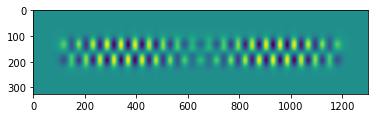

In [28]:
plt.imshow(morb_planes[50].T)
plt.show()

In [ ]:
def write_cube_file(filename, file_xyz, cell, cell_n, data):
    
    # Read atomic positions (a.u.)
    positions, elems_nrs = read_atoms(file_xyz)
    
    natoms = len(positions)
    origin = np.array([0.0, 0.0, 0.0])
    origin *= ang_2_bohr
    
    f = open(filename, 'w')
    
    f.write('title\n')
    f.write('comment\n')
    
    dv_br = cell/cell_n
    dv_br = dv_br * np.diag([1, 1, 1])
    
    f.write("%5d %12.6f %12.6f %12.6f\n"%(natoms, origin[0], origin[1], origin[2]))
    
    for i in range(3):
        f.write("%5d %12.6f %12.6f %12.6f\n"%(cell_n[i], dv_br[i][0], dv_br[i][1], dv_br[i][2]))
    
    for i in range(natoms):
        at_x = positions[i][0]
        at_y = positions[i][1]
        at_z = positions[i][2]
        f.write("%5d %12.6f %12.6f %12.6f %12.6f\n"%(elems_nrs[i][1], 0.0, at_x, at_y, at_z))
    
    data.tofile(f, sep='\n', format='%12.6e')
    
    f.close()
    